### 01_Generate the Dataloader 
    input : text_file
            {img1 img2 1
             img3 img4 0
             img1 img5 1}
             
    output : {transformed_tensor1 transformed_tensor 2 similarity_label}
     

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

#### Face detection using MTCNN

In [2]:
from mtcnn.mtcnn import MTCNN

def align_face(im):
    im = np.asarray(im)
    detector = MTCNN()
    results = detector.detect_faces(im)

    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = im[y1:y2, x1:x2]

    face_image = Image.fromarray(face)
    
    return face_image

Using TensorFlow backend.


#### Augmentation Techniques

In [3]:
train_time_augmentations = transforms.Compose([transforms.Resize((160,160)),
                                               transforms.RandomAffine(15),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ColorJitter(
                                                          brightness=0.3,
                                                          contrast=0.3,
                                                          saturation=0.3),
                                               transforms.ToTensor()])
test_time_augmentations  = transforms.Compose([transforms.Resize((160,160)),
                                               transforms.ToTensor()])

In [4]:
class Face_Dataset(Dataset):
    
    def __init__(self, root_dir='../lfw/', file_root = "../files/", train=False, test=False):
        
        self.train = train
        self.test = test
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        
        dataset = set()
        if self.train:
            filename= file_root + 'couples/train.txt'
        else:
            filename= file_root + 'couples/test.txt'
            
        self.transform = self.load_transforms()

        with open(filename) as f:
            for line in f:
                line = line.split()
                self.files.append(line[:2])
                self.labels.append(int(line[2]))
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        im_names = self.files[idx]
        im1 = Image.open(os.path.join(self.root_dir, im_names[0]))
        im2 = Image.open(os.path.join(self.root_dir, im_names[1]))
        # label is 1 if the two images are of dissimilar classes
        label = np.array([abs(1-self.labels[idx])],dtype=np.float32)
        
        # cropping face from image
        im1 = align_face(im1)
        im2 = align_face(im2)
        
        #  applying augmentations on the crpped face
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
            
        label = torch.from_numpy(label)
        return im1, im2, label
    
    @staticmethod
    def align_face(im):
        im = np.asarray(im)
        detector = MTCNN()
        results = detector.detect_faces(im)

        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = im[y1:y2, x1:x2]

        face_image = Image.fromarray(face)

        return face_image
    
    def load_transforms(self):
        if self.train:
            tet = transforms.Compose([transforms.Resize((160,160)),
                                               transforms.RandomAffine(15),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ColorJitter(
                                                          brightness=0.3,
                                                          contrast=0.3,
                                                          saturation=0.3),
                                               transforms.ToTensor()])
        else:
            tet = transforms.Compose([transforms.ToTensor()])
        return tet

In [5]:
face_data = Face_Dataset("../lfw/",train=True)

In [6]:
face_data[0][0].shape,face_data[0][1].shape,face_data[101][2]

(torch.Size([3, 160, 160]), torch.Size([3, 160, 160]), tensor([1.]))

dissimilar


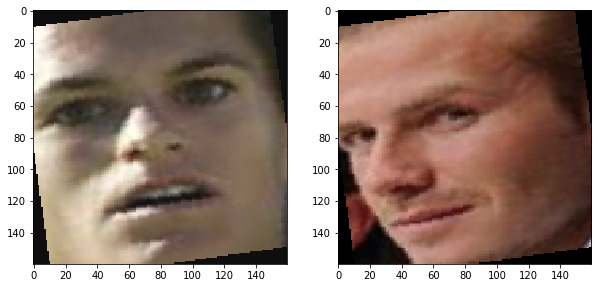

dissimilar


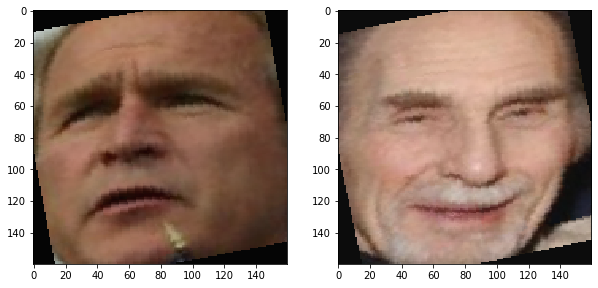

dissimilar


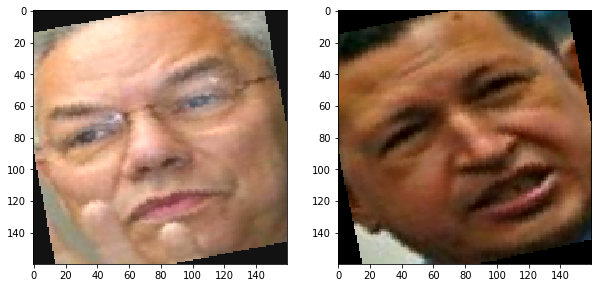

similar


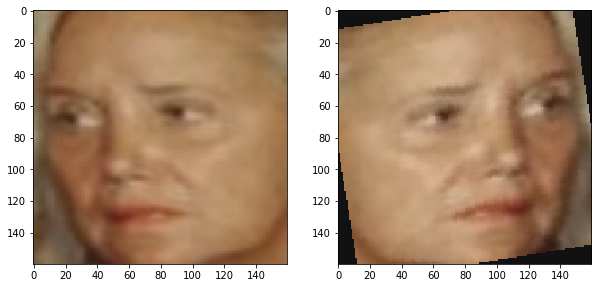

similar


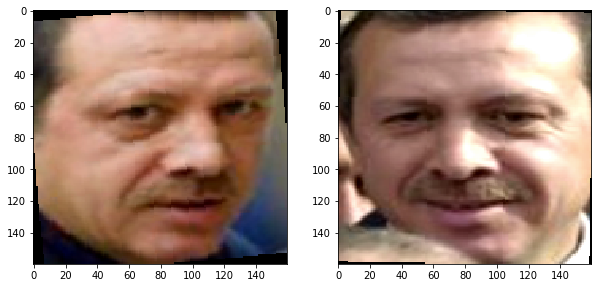

In [7]:
for i in range(5):
    index = random.randint(1,2000)
    img1 = transforms.ToPILImage()(face_data[index][0])
    img2 = transforms.ToPILImage()(face_data[index][1])
    label = face_data[index][2].item()
    
    similar = 'similar' if label==0.0 else 'dissimilar' 
    
    print(similar)
    fig = plt.figure(figsize=(10,10))
    ax = []
    ax.append(fig.add_subplot(1,2,1))
    plt.imshow(img1)
    
    ax.append(fig.add_subplot(1,2,2))
    plt.imshow(img2)
    
    plt.show()
